In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy.stats import chi2_contingency
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [28]:
# input files/dirs
POG570_MUTATIONS = "../data/POG570/POG570_small_mutations.txt" 
MUT_ANNOT = "../data/POG570/mutations_annotated.tsv"
CNV_DATA = "../data/POG570/POG570_cnv_segments_with_ratios.tsv"
PANCANCER_DRIVERS = "../data/driver_genes/Pancancer.tsv"
HOTSPOTS = "../data/datasets/cancer_hotspots_drivers/hotspots_v2"
POG_COHORT_MAP = "../metadata/POG570_cohorts.tsv"
SURVIVAL_DATA = "../data/POG570/survival.csv"

# output files/dirs
RESULTS = "../results/POG570"
os.makedirs(RESULTS, exist_ok=True)

## Annotating Driver Mutations

In [29]:
driver_genes = pd.read_csv(PANCANCER_DRIVERS, sep="\t")
driver_gene_set = set(driver_genes["gene"].unique())
driver_gene_lengths = dict(zip(driver_genes["gene"], driver_genes["gene_length"]))
driver_gene_strand = dict(zip(driver_genes["gene"], driver_genes["strand"]))

In [30]:
organ_project_map = pd.read_csv(POG_COHORT_MAP, sep="\t")
cohorts_without_hotspots = set(organ_project_map[organ_project_map["hotspot_organ"].isna()]["cohort"])
print("Cohorts without hotspot mapping:", cohorts_without_hotspots)
cohorts_with_hotspots = set(organ_project_map[organ_project_map["hotspot_organ"].notna()]["cohort"])
print("Cohorts with hotspot mapping:", cohorts_with_hotspots)
organ_project_map.dropna(inplace=True)
organ_project_map["hotspot_organ"] = organ_project_map["hotspot_organ"].str.split(",")
organ_project_map = organ_project_map.explode("hotspot_organ")
organ_project_map_dict = dict(zip(organ_project_map["hotspot_organ"], organ_project_map["cohort"]))
cohorts_without_hotspots = set(organ_project_map[organ_project_map["hotspot_organ"].isna()]["cohort"])

Cohorts without hotspot mapping: {'BCC', 'SECR', 'MISC'}
Cohorts with hotspot mapping: {'LUNG', 'UVM', 'ACC', 'CHOL', 'CERV', 'HNSC', 'ESCA', 'PRAD', 'THYM', 'UCEC', 'COLO', 'OV', 'LYMP', 'SKCM', 'HCC', 'KDNY', 'CNS-PNS', 'SARC', 'STAD', 'BRCA', 'PANC', 'BLCA', 'THCA'}


In [31]:
indel_hotspots = pd.read_csv(f"{HOTSPOTS}/INDEL-hotspots.tsv", sep="\t")
snv_hotspots = pd.read_csv(f"{HOTSPOTS}/SNV-hotspots.tsv", sep="\t")
drivers_hotspots = pd.concat([indel_hotspots, snv_hotspots])
drivers_hotspots = drivers_hotspots[["Hugo_Symbol", "Genomic_Position", "Codon_Change", "Organ_Types", "qvalue"]]
drivers_hotspots = drivers_hotspots[drivers_hotspots["qvalue"] < 0.05]
drivers_hotspots["Genomic_Position"] = drivers_hotspots["Genomic_Position"].str.split("|")
drivers_hotspots = drivers_hotspots.explode("Genomic_Position")
drivers_hotspots["Genomic_Position"] = drivers_hotspots["Genomic_Position"].str.split("_").str[0]
drivers_hotspots = drivers_hotspots[["Hugo_Symbol", "Genomic_Position", "Organ_Types"]]
drivers_hotspots.drop_duplicates(inplace=True)
drivers_hotspots["Organ_Types"] = drivers_hotspots["Organ_Types"].str.split("|")
drivers_hotspots = drivers_hotspots.explode("Organ_Types")
drivers_hotspots["Organ_Types"] = drivers_hotspots["Organ_Types"].str.split(":").str[0]
drivers_hotspots["Cohort"] = drivers_hotspots["Organ_Types"].map(organ_project_map_dict)
drivers_hotspots["Cohort"] = drivers_hotspots["Cohort"].str.split(", ")
drivers_hotspots = drivers_hotspots[["Hugo_Symbol", "Genomic_Position", "Cohort"]]
print(drivers_hotspots.shape)
drivers_hotspots = drivers_hotspots.explode("Cohort")
print(drivers_hotspots.shape)
drivers_hotspots.drop_duplicates(inplace=True)
drivers_hotspots.dropna(inplace=True)
# driver hotspot data
hotspot_set = set(zip(drivers_hotspots['Cohort'], drivers_hotspots['Genomic_Position']))

(15473, 3)
(15473, 3)


In [32]:
# SNPs and Indels data
mut_df = pd.read_csv(POG570_MUTATIONS, sep="\t") # hg19 coordinates
mut_df = mut_df[["patient_id", "library_name", "chrom", "pos", "ref", "alt", "gene_id", "analysis_cohort"]]
print(mut_df.shape, mut_df['analysis_cohort'].nunique())
# remove samples with no hotspot data
mut_df = mut_df[mut_df['analysis_cohort'].isin(cohorts_with_hotspots)]
print(mut_df.shape, mut_df['analysis_cohort'].nunique())
mut_df.drop_duplicates(inplace=True)
print(mut_df.shape)
mut_df["mutation_pos"] = mut_df["chrom"].astype(str) + ":" + mut_df["pos"].astype(str)
mut_df["mutation"] = mut_df["mutation_pos"] + ":" + mut_df["ref"] + ":" + mut_df["alt"]
# hotspot annotation
mut_df['is_hotspot'] = mut_df.apply(
    lambda row: (row['analysis_cohort'], row['mutation_pos']) in hotspot_set, axis=1
)

(8142477, 8) 26
(7279344, 8) 23
(7279344, 8)


In [33]:
# CNV burden
cnv_data_df = pd.read_csv(CNV_DATA, sep="\t")
# get altered regions, copy_number = 2 represents normal diploid state
cnv_data_df = cnv_data_df[cnv_data_df["copy_number"] != 2]
cnv_data_df["cna_length"] = cnv_data_df["end_position"] - cnv_data_df["start_position"] + 1
cnv_data_df = cnv_data_df.groupby("pog_id").agg({
    "cna_length": "sum"
}).reset_index()
cnv_data_df["cna_burden"] = cnv_data_df["cna_length"] * 100 / (2 * 3.1e+09) # diploid genome size
cnv_data_df.drop(columns=["cna_length"], inplace=True)
print(cnv_data_df.shape)

(570, 2)


In [34]:
mut_annot = pd.read_csv(MUT_ANNOT, sep="\t")
mut_annot.drop_duplicates(inplace=True)
print(mut_annot.shape)
mut_annot_df = pd.merge(mut_df, mut_annot, on="mutation", how="left")
print(mut_annot_df.shape)
# genome-wide mutation burden
mut_burden = mut_annot_df.groupby("patient_id").agg({
	"mutation": "nunique"
}).reset_index().rename(columns={"mutation": "mut_burden"})
mut_annot_df = mut_annot_df.merge(mut_burden, on="patient_id", how="left")
print(mut_annot_df.shape)
mut_annot_df = mut_annot_df[mut_annot_df['genic_region'] != "intergenic"]
mut_annot_df.dropna(subset=["gene"], inplace=True)
mut_annot_df["gene"] = mut_annot_df["gene"].apply(lambda x: x.split("(")[0])
mut_annot_df["gene_strand"] = mut_annot_df["gene"].map(driver_gene_strand)
mut_annot_df["gene_length"] = mut_annot_df["gene"].map(driver_gene_lengths)
mut_annot_df["in_driver_gene"] = mut_annot_df.apply(
    lambda x: x["gene"] in driver_gene_set, axis=1
)
print(mut_annot_df.shape)

(8053746, 3)
(7279533, 13)
(7279533, 14)
(2795189, 17)


In [35]:
mut_in_driver_genes = mut_annot_df[mut_annot_df["in_driver_gene"]]
mut_in_driver_genes = mut_in_driver_genes[["patient_id", "mutation", "gene", "gene_strand", "genic_region", "is_hotspot", "analysis_cohort"]]
print(mut_in_driver_genes.shape)

(15792, 7)


## Passenger density Analysis

In [36]:
# passenger mutation density
mut_df_passenger_density = mut_annot_df.groupby(["patient_id", "gene"]).agg({
	"is_hotspot": lambda x: x.value_counts().get(False, 0),
}).reset_index().rename(columns={"is_hotspot": "passenger_density"})
print(mut_df_passenger_density.shape)

(1311580, 3)


In [37]:
# driver mutation status
mut_df_grouped = mut_annot_df.groupby(["patient_id", "gene"]).agg({
	"analysis_cohort": "first",
	"is_hotspot": "any",
	"mut_burden": "first",
}).reset_index()
mut_df_grouped.rename(columns={"is_hotspot": "has_hotspot"}, inplace=True)
print(mut_df_grouped.shape)
mut_df_grouped = mut_df_grouped.merge(mut_df_passenger_density, on=["patient_id", "gene"], how="left")
mut_df_grouped["passenger_density"].fillna(0, inplace=True)
print(mut_df_grouped.shape)

(1311580, 5)
(1311580, 6)


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94506/2034836592.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mut_df_grouped["passenger_density"].fillna(0, inplace=True)


In [38]:
# restrict the analysis to driver genes only
mut_df_grouped["in_driver_gene"] = mut_df_grouped.apply(
    lambda x: x["gene"] in driver_gene_set, axis=1
)
print(mut_df_grouped.shape)
mut_df_grouped = mut_df_grouped[mut_df_grouped["in_driver_gene"]]
mut_df_grouped.drop(columns=["in_driver_gene"], inplace=True)
print(mut_df_grouped.shape)

(1311580, 7)
(2338, 6)


In [39]:
# add rows for samples with no mutations in driver genes
patients = mut_df_grouped["patient_id"].unique()
passenger_density = mut_df_grouped.copy()
for patient in patients:
	cohort = mut_df_grouped[mut_df_grouped["patient_id"] == patient]["analysis_cohort"].values[0]
	for gene in driver_gene_set:
		if len(passenger_density[(passenger_density["patient_id"] == patient) & (passenger_density["gene"] == gene)]) == 0:
			passenger_density = pd.concat([passenger_density, pd.DataFrame({
				"analysis_cohort": [cohort],
				"patient_id": [patient], 
				"gene": [gene], 
				"has_hotspot": [False],
				"passenger_density": [0],
				"mut_burden": [0],
			})])
print(passenger_density.shape)

(8070, 6)


In [40]:
# add gene length, cna burden
passenger_density["gene_length"] = passenger_density["gene"].map(driver_gene_lengths)
print(passenger_density.shape)
passenger_density = passenger_density.merge(cnv_data_df, left_on="patient_id", right_on="pog_id", how="left")
passenger_density.drop(columns=["pog_id"], inplace=True)
print(passenger_density.shape)
passenger_density["adj_passenger_density"] = passenger_density.apply(
	lambda x: (x["passenger_density"] * 3.2e9 / (x["mut_burden"] * x["gene_length"] * x["cna_burden"])
			   if x["passenger_density"] > 0 else 0), axis=1
)

(8070, 7)
(8070, 8)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test smaller, P_val:4.413e-10 U_stat=1.204e+06


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94506/2730303436.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94506/2730303436.py:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.barplot(


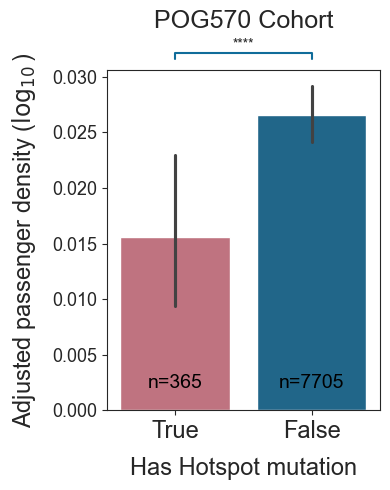

In [41]:
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
passenger_density["passenger_density_log"] = passenger_density["adj_passenger_density"].apply(lambda x: np.log10(x + 1))

plt.figure(figsize=(4, 5))
ax = sns.barplot(
    x="has_hotspot",
    y="passenger_density_log",
    data=passenger_density,
    order=[True, False],
    palette=cmap
)

# show number of data points
for i, has_hotspot in enumerate([True, False]):
    n = passenger_density[passenger_density["has_hotspot"] == has_hotspot].shape[0]
    plt.text(i, 0.002, f"n={n}", ha='center', fontsize=14, color='black')
    
# get statistical significance annotations
annotator = Annotator(
    ax, 
    data=passenger_density, 
    x="has_hotspot",
    y="passenger_density_log", 
    pairs=[(True, False)],
    order=[True, False]
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.apply_and_annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.apply_and_annotate()

plt.xlabel("Has Hotspot mutation", fontsize=17, labelpad=10)
plt.xticks(fontsize=17)
plt.yticks(fontsize=13)
plt.ylabel(r"Adjusted passenger density ($\log_{10}$)", fontsize=17, labelpad=10)
plt.title("POG570 Cohort", fontsize=18, pad=30)
plt.tight_layout()
plt.savefig(f"{RESULTS}/passenger_density_pancancer_genes.png", dpi=300)

## Observed vs Expected

In [42]:
upper_limit = 5
passenger_counts = passenger_density[["has_hotspot", "passenger_density"]].copy()
passenger_counts = passenger_counts[passenger_counts["passenger_density"] <= upper_limit]
passenger_counts.head()

,has_hotspot,passenger_density
0,False,2
1,True,0
3,False,2
4,False,1
5,False,1


In [43]:
# chi-square test
observed = pd.crosstab(
    passenger_counts["has_hotspot"],
    passenger_counts["passenger_density"],
)
print(observed)
stat, p, dof, expected = chi2_contingency(observed)
print(f"p-value: {p}, stat: {stat}")
print(expected)

expected_df = pd.DataFrame(expected, columns=observed.columns, index=observed.index)
expected_df = expected_df.rename_axis(index=None, columns=None)
observed_df = pd.DataFrame(observed, columns=observed.columns, index=observed.index)
observed_df = observed_df.rename_axis(index=None, columns=None)

# get the difference between observed and expected for corresponding cells
residuals = observed_df - expected_df
residuals.head()

passenger_density     0    1    2    3    4   5
has_hotspot                                    
False              5732  806  276  145  110  65
True                327   28    4    3    1   0
p-value: 0.00015814282146099746, stat: 24.714997779301438
[[5.76562705e+03 7.93618247e+02 2.66442577e+02 1.40833934e+02
  1.05625450e+02 6.18527411e+01]
 [2.93372949e+02 4.03817527e+01 1.35574230e+01 7.16606643e+00
  5.37454982e+00 3.14725890e+00]]


,0,1,2,3,4,5
False,-33.627051,12.381753,9.557423,4.166066,4.37455,3.147259
True,33.627051,-12.381753,-9.557423,-4.166066,-4.37455,-3.147259


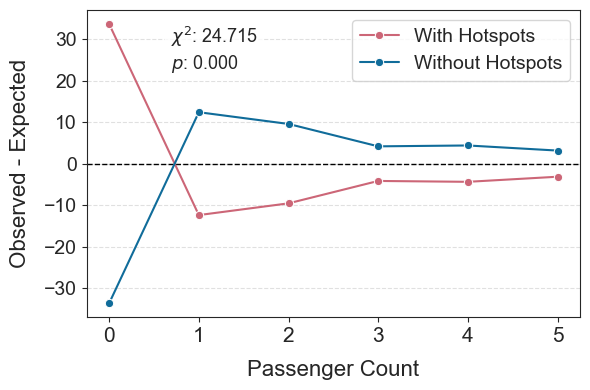

In [44]:
plt.figure(figsize=(6, 4))

# horizontal line at y=0
plt.axhline(0, color='black', lw=1, ls='--')

sns.lineplot(
	x=residuals.columns,
	y=residuals.loc[True],
	color=colors[0],
	label="With Hotspots",
	marker="o",
)

sns.lineplot(
	x=residuals.columns,
	y=residuals.loc[False],
	color=colors[1],
	label="Without Hotspots",
	marker="o",
)

# add p-value annotation
plt.annotate(
	rf"$\chi^2$: {stat:.3f}" + "\n" + rf"$p$: {p:.3f}", 
	xy=(0.17, 0.95), 
	xycoords='axes fraction', 
	fontsize=13, 
	ha='left', 
	va='top',
	bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)

plt.xlabel("Passenger Count", fontsize=16, labelpad=10)
plt.xticks([i for i in range(0, upper_limit + 1)], fontsize=15)
plt.ylabel("Observed - Expected", fontsize=16, labelpad=10)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(f"{RESULTS}/passenger_count_chi_square_residuals_pancancer_drivers.png", dpi=300)

## Overall Survival Analysis

In [45]:
survival_df = pd.read_csv(SURVIVAL_DATA)
print(survival_df.shape)
survival_df.head()

(570, 3)


,patient_id,days,event
0,11004,247,1
1,11307,836,1
2,11698,2554,1
3,12255,294,1
4,13009,2196,0


In [46]:
def get_mut_status(row):
    if row["has_hotspot"]:
        return "Has Hotspot"
    else:
        if row["passenger_density"] > 0:
            return "Passengers only"
        else:
            return "No mutation"

In [47]:
patient_data = passenger_density[["patient_id", "gene", "analysis_cohort", "has_hotspot", "passenger_density", "adj_passenger_density"]]
patient_data["mutation_status"] = patient_data.apply(lambda x: get_mut_status(x), axis=1)
print(patient_data.shape)
patient_data.drop_duplicates(inplace=True)
print(patient_data.shape)
patient_data = patient_data.merge(survival_df, on="patient_id", how="left")
print(patient_data.shape)
patient_data.head()

(8070, 7)
(8070, 7)
(8070, 9)


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94506/607466240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data["mutation_status"] = patient_data.apply(lambda x: get_mut_status(x), axis=1)
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94506/607466240.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data.drop_duplicates(inplace=True)


,patient_id,gene,analysis_cohort,has_hotspot,passenger_density,adj_passenger_density,mutation_status,days,event
0,11004,APC,COLO,False,2,0.322015,Passengers only,247,1
1,11004,BRAF,COLO,True,0,0.000000,Has Hotspot,247,1
2,11004,CSMD3,COLO,False,15,0.275972,Passengers only,247,1
3,11004,CTNNB1,COLO,False,2,0.684600,Passengers only,247,1
4,11004,IDH1,COLO,False,1,0.748409,Passengers only,247,1


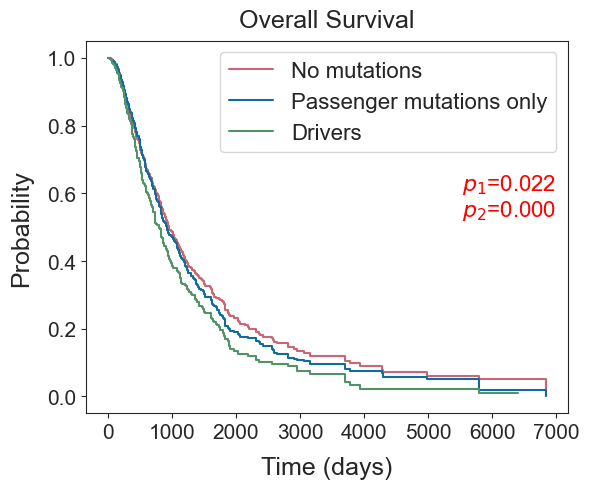

In [48]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

# KAPLAN-MEIER PLOTS
plt.figure(figsize=(6, 5))
sns.set_style("ticks")

# samples with no mutations in the gene
kmf_control = KaplanMeierFitter()
group0 = patient_data[patient_data["mutation_status"] == "No mutation"]
kmf_control_result = kmf_control.fit(group0["days"], group0["event"], label='No mutations')
kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False)

# "no mutations" vs "passengers"
categories = ["Passengers only"]
group1 = patient_data[patient_data["mutation_status"].isin(categories)]
if len(group1) > 0:
	kmf_exp1 = KaplanMeierFitter()
	kmf_exp1_result = kmf_exp1.fit(group1["days"], group1["event"], label='Passenger mutations only')
	kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False)
	results1 = logrank_test(group0['days'], group1['days'], event_observed_A=group0['event'], event_observed_B=group1['event'])
	p_value1 = results1.p_value
	color1 = 'red' if p_value1 < 0.05 else 'black'
	plt.text(0.78, 0.6, rf"$\it{{p}}_1$={p_value1:.3f}",
		transform=plt.gca().transAxes, fontsize=16, color=color1)

# "no mutations" vs "drivers"
group2 = patient_data[patient_data["mutation_status"] == "Has Hotspot"]
if len(group2) > 0:
	kmf_exp2 = KaplanMeierFitter()
	kmf_exp2_result = kmf_exp2.fit(group2["days"], group2["event"], label='Drivers')
	kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False)
	results2 = logrank_test(group0['days'], group2['days'], event_observed_A=group0['event'], event_observed_B=group2['event'])
	p_value2 = results2.p_value
	color3 = 'red' if p_value2 < 0.05 else 'black'
	plt.text(0.78, 0.53, rf"$\it{{p}}_2$={p_value2:.3f}", 
			transform=plt.gca().transAxes, fontsize=16, color=color3)

plt.ylabel('Probability', labelpad=10, fontsize=18)
plt.xlabel('Time (days)', labelpad=10, fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=16, loc='upper right')
plt.title("Overall Survival", fontsize=18, pad=10)
plt.tight_layout()
plt.savefig(f"{RESULTS}/overall_survival.png", dpi=300)

## Median Survival

In [49]:
results = []
groups = ["No mutation", "Passengers only", "Has Hotspot"]
labels = ["No mutations", "Passenger mutations only", "Drivers"]

# get max duration
max_time = 0

driver_genes_list = patient_data["gene"].unique().tolist()
for gene in driver_genes_list:
	tumor_gene_has_driver_data_selected = patient_data[patient_data["gene"] == gene]
	# print(groups)
	for i, group in enumerate(groups):
		group_df = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == group]
		max_time = max(max_time, group_df["days"].max())
		if len(group_df) == 0:
			continue
		kmf = KaplanMeierFitter()
		kmf.fit(group_df["days"], group_df["event"], label='No mutations')
		median = kmf.median_survival_time_
		results.append({
			'gene': gene,
			'group': labels[i],
			'median_survival': median,
		})
		# print(f"  Group: {labels[i]}, n={len(group_df)}, median survival: {median}")
results_df = pd.DataFrame(results)
results_df['median_survival'] = results_df['median_survival'].replace(np.inf, max_time)
results_df.head()

,gene,group,median_survival
0,APC,No mutations,945.0
1,APC,Passenger mutations only,924.0
2,APC,Drivers,1138.0
3,BRAF,No mutations,939.0
4,BRAF,Passenger mutations only,960.0


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No mutations vs. Passenger mutations only: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:1.541e-02 U_stat=1.650e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94506/1061288921.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94506/1061288921.py:2: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.boxplot(


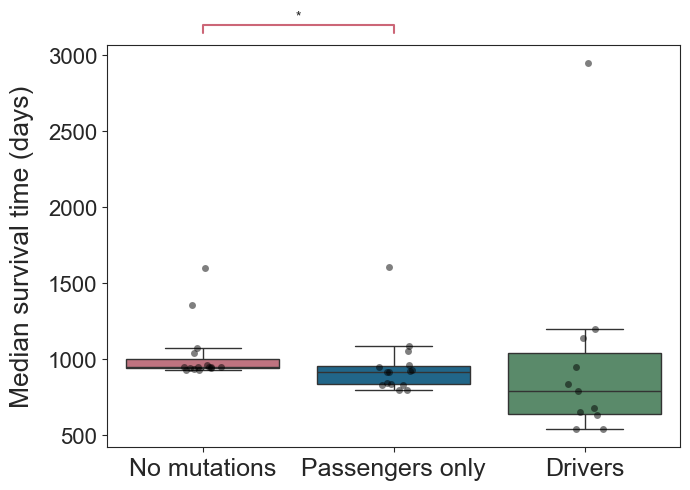

In [50]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(
    data=results_df, 
    x='group', 
    y='median_survival',
    order=labels,
    showfliers=False,
    palette=cmap,
)
sns.stripplot(
	data=results_df, 
	x='group', 
	y='median_survival',
	order=labels,
	color='black',
	alpha=0.5,
	size=5,
)

# get statistical significance annotations
annotator = Annotator(
    ax, 
    data=results_df, 
    x="group",
    y="median_survival", 
    pairs=[(labels[0], labels[1]), (labels[1], labels[2])],
    order=labels,
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

plt.xticks(ticks=[0, 1, 2], \
	labels=["No mutations", "Passengers only", "Drivers"], fontsize=18)
plt.xlabel('')
plt.yticks(fontsize=16)
plt.ylabel('Median survival time (days)', fontsize=19, labelpad=10)
plt.tight_layout()
plt.savefig(f"{RESULTS}/median_survival.png", dpi=300)